In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
try:
    from tensorflow import keras
    from tensorflow.keras import layers, callbacks
except ImportError:
    import keras
    from keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')

import random

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [3]:
TARGETS = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
TEMPORAL_FEATURES = ['hour', 'is_day', 'hour_sin', 'hour_cos', 'dow', 'dow_sin', 
                     'dow_cos', 'is_holiday', 'is_weekend', 'lockdown_code']

LAGS = [6, 12, 24]

In [4]:
train_df = pd.read_csv("../data/train_features.csv")
test_df = pd.read_csv("../data/test_features_to_predict.csv")


In [5]:

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (40991, 213)
Test shape: (504, 208)


In [6]:
print("\nPreparing training data...")
# Identify all lag/roll columns (anything with lag_ or roll_)
all_cols = train_df.columns.tolist()
lag_roll_cols = [c for c in all_cols if 'lag_' in c or 'roll_' in c]
feature_cols = lag_roll_cols + TEMPORAL_FEATURES

print(f"Using {len(feature_cols)} features for training")
print(f"  - Lag/Roll features: {len(lag_roll_cols)}")
print(f"Targets: {TARGETS}")

# Remove rows with NaN in features or targets
train_clean = train_df[feature_cols + TARGETS].dropna()
print(f"Train samples after removing NaNs: {len(train_clean)}")

X_train_full = train_clean[feature_cols].values
Y_train_full = train_clean[TARGETS].values


Preparing training data...
Using 204 features for training
  - Lag/Roll features: 194
Targets: ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
Train samples after removing NaNs: 40991


In [7]:
split_idx = int(0.85 * len(X_train_full))
X_train = X_train_full[:split_idx]
Y_train = Y_train_full[:split_idx]
X_val = X_train_full[split_idx:]
Y_val = Y_train_full[split_idx:]

print(f"\nTrain samples: {X_train.shape[0]}")
print(f"Val samples: {X_val.shape[0]}")


Train samples: 34842
Val samples: 6149


In [8]:
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Scale targets per pollutant
target_scalers = {}
Y_train_scaled = np.zeros_like(Y_train, dtype=np.float32)
Y_val_scaled = np.zeros_like(Y_val, dtype=np.float32)

for i, target in enumerate(TARGETS):
    scaler_t = StandardScaler()
    Y_train_scaled[:, i] = scaler_t.fit_transform(Y_train[:, i:i+1]).ravel()
    Y_val_scaled[:, i] = scaler_t.transform(Y_val[:, i:i+1]).ravel()
    target_scalers[target] = scaler_t


Scaling features...


In [ ]:
print("\nBuilding model...")  

n_features = X_train_scaled.shape[1]
n_targets = len(TARGETS)

print(f"Model input features: {n_features}")

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(n_features,)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(n_targets)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print(model.summary())



Building GRU model...
Model input features: 204


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        13,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,813 (61.77 KB)

 Trainable params: 15,813 (61.77 KB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
print("\nTraining model...")

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    epochs=150,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Training model...
Epoch 1/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5792 - mae: 0.5461 - val_loss: 0.3131 - val_mae: 0.3867
Epoch 2/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3731 - mae: 0.4302 - val_loss: 0.2685 - val_mae: 0.3508
Epoch 3/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3316 - mae: 0.4018 - val_loss: 0.2514 - val_mae: 0.3345
Epoch 4/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3079 - mae: 0.3853 - val_loss: 0.2420 - val_mae: 0.3243
Epoch 5/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2893 - mae: 0.3727 - val_loss: 0.2358 - val_mae: 0.3167
Epoch 6/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2760 - mae: 0.3631 - val_loss: 0.2263 - val_mae: 0.3084
Epoch 7/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2677 - mae: 0.3562 - val_loss: 0.2226 - val_mae: 0.3039
Epoch 8/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2614 - mae: 0.3501 - val_loss: 0.2190 - val_mae: 0.2969
Epoch 9/150
273/273 ━━━━━━━━━

In [11]:
print("\nValidation MAE per pollutant:")
Y_val_pred_scaled = model.predict(X_val_scaled, verbose=0)

mae_per_pollutant = []
for i, target in enumerate(TARGETS):
    y_pred_unscaled = target_scalers[target].inverse_transform(Y_val_pred_scaled[:, i:i+1])
    mae = mean_absolute_error(Y_val[:, i], y_pred_unscaled)
    mae_per_pollutant.append(mae)
    print(f"  {target}: {mae:.4f}")

final_score_val = np.mean(mae_per_pollutant)
print(f"\nValidation Final Score (avg MAE): {final_score_val:.4f}")


Validation MAE per pollutant:
  valeur_NO2: 4.4575
  valeur_CO: 0.0268
  valeur_O3: 7.6562
  valeur_PM10: 3.0841
  valeur_PM25: 1.9645

Validation Final Score (avg MAE): 3.4378


In [12]:
print("feature_cols length:", len(feature_cols))
print("train_df columns:", train_df.shape[1])
print("\nColumns in train but not in feature_cols:")
missing = [c for c in train_df.columns if c not in feature_cols and c not in ['id', 'datetime', 'valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']]
print(missing[:20])

feature_cols length: 204
train_df columns: 213

Columns in train but not in feature_cols:
['NO2_lag1_for_O3', 'PM10_lag1_for_PM25']


In [13]:
print("Columns in X_train_scaled:", X_train_scaled.shape[1])
print("Columns in feature_cols:", len(feature_cols))

Columns in X_train_scaled: 204
Columns in feature_cols: 204


In [14]:
# ============================================================================
# PREPARE TEST DATA - ROLLING AVERAGE APPROACH
# ============================================================================
print("\nPreparing test data with rolling lag features...")

# Get last 24 rows of train to use for averaging (more realistic than single row)
last_24_rows = train_df.iloc[-24:].copy()

print(f"feature_cols length: {len(feature_cols)}")
print(f"Using last 24 rows of train for feature averaging")

# Build test features: average features from last 24 train rows, update temporal from test_df
test_features_list = []

for idx in range(len(test_df)):
    test_row = test_df.iloc[idx].copy()
    
    # Average each feature across last 24 train rows
    base_features = []
    for col in feature_cols:
        if col in last_24_rows.columns:
            # For temporal features, we'll override later; for others, take mean
            if col not in TEMPORAL_FEATURES:
                feat_val = float(last_24_rows[col].mean())
            else:
                feat_val = float(last_24_rows[col].iloc[-1])  # Use last value for temporal
            base_features.append(feat_val)
        else:
            base_features.append(0.0)
    
    base_features = np.array(base_features)
    
    # Update temporal features from test_df (these change for each test row)
    for i, col in enumerate(feature_cols):
        if col in TEMPORAL_FEATURES and col in test_row.index:
            base_features[i] = float(test_row[col])
    
    test_features_list.append(base_features)

X_test = np.array(test_features_list)
print(f"Test features shape: {X_test.shape}")
print(f"Expected features: {n_features}")

# Scale test features
X_test_scaled = scaler.transform(X_test)



Preparing test data with rolling lag features...
feature_cols length: 204
Using last 24 rows of train for feature averaging
Test features shape: (504, 204)
Expected features: 204


In [15]:
print("\nPredicting on test set...")
Y_test_pred_scaled = model.predict(X_test_scaled, verbose=0)

# Inverse scale predictions
Y_test_pred = np.zeros_like(Y_test_pred_scaled)
for i, target in enumerate(TARGETS):
    Y_test_pred[:, i] = target_scalers[target].inverse_transform(Y_test_pred_scaled[:, i:i+1]).ravel()

print(f"Test predictions shape: {Y_test_pred.shape}")


Predicting on test set...
Test predictions shape: (504, 5)


In [16]:
print("\nCreating submission file...")

submission = pd.DataFrame()
submission['id'] = test_df['id'].values

for i, target in enumerate(TARGETS):
    submission[target] = Y_test_pred[:, i]

submission.to_csv('ffnn_submission.csv', index=False)
print("✅ Submission saved to submission.csv")
print(f"\nSubmission preview:\n{submission.head()}")
print(f"\nSubmission shape: {submission.shape}")


Creating submission file...
✅ Submission saved to submission.csv

Submission preview:
              id  valeur_NO2  valeur_CO  valeur_O3  valeur_PM10  valeur_PM25
0  2024-09-03 23   16.238300   0.165048  46.274651     9.706117     5.203849
1  2024-09-04 00   14.761790   0.159205  49.041630     9.820264     5.214915
2  2024-09-04 01   15.178182   0.159888  48.087521     9.607434     5.126313
3  2024-09-04 02   15.758050   0.161021  47.292908     9.498759     5.080022
4  2024-09-04 03   16.446770   0.162573  46.570362     9.514306     5.088786

Submission shape: (504, 6)


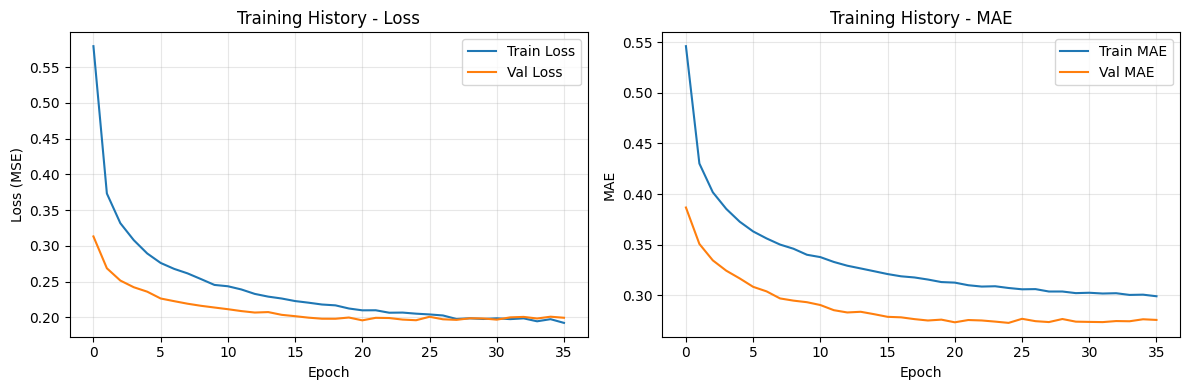

✅ Training history plot saved to training_history.png


In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training History - Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training History - MAE')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_history.png', dpi=100, bbox_inches='tight')
plt.show()

print("✅ Training history plot saved to training_history.png")

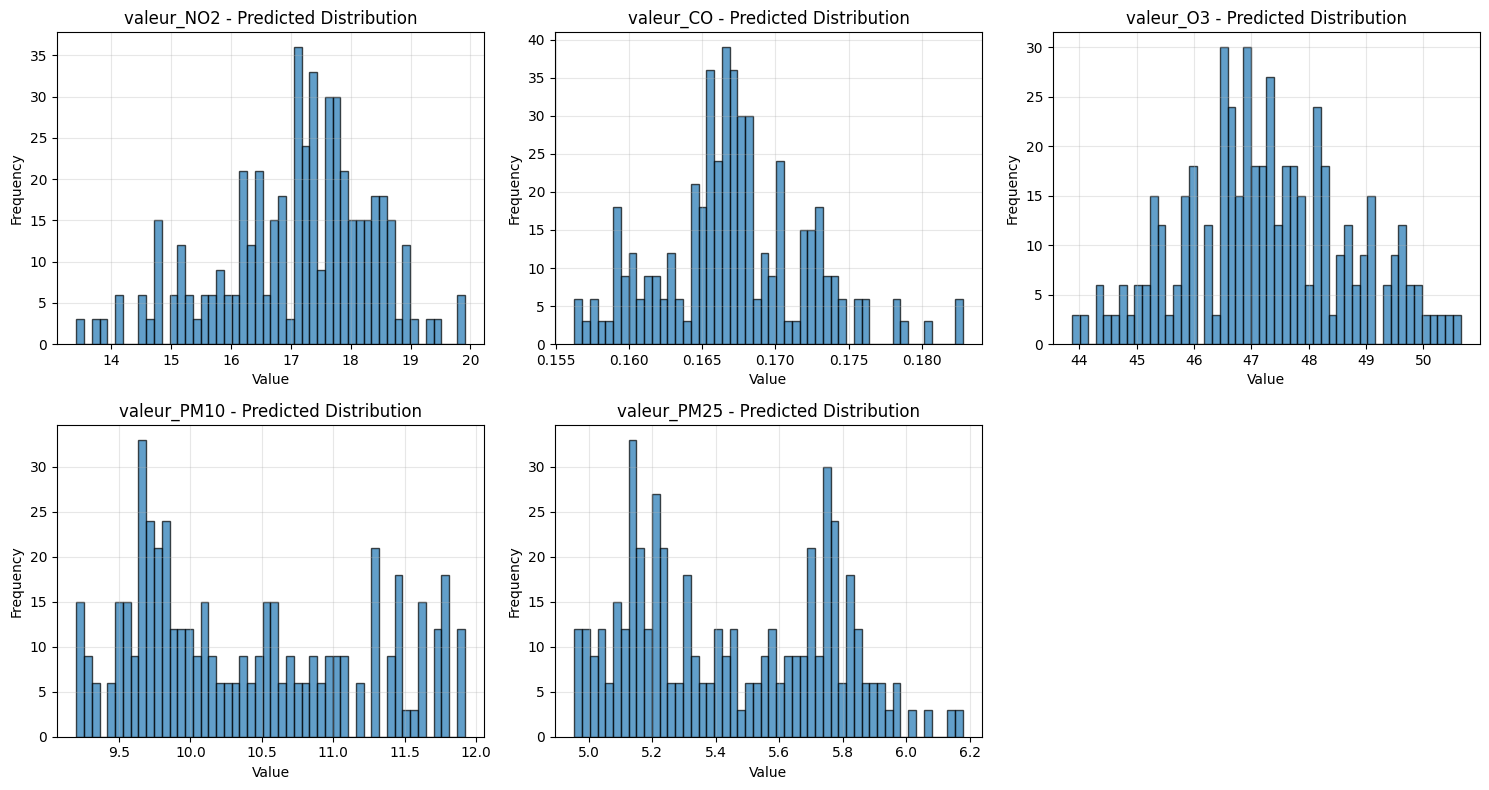

✅ Predictions distribution plot saved to predictions_distribution.png


In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, target in enumerate(TARGETS):
    axes[i].hist(Y_test_pred[:, i], bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{target} - Predicted Distribution')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

axes[5].axis('off')
plt.tight_layout()
plt.savefig('predictions_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print("✅ Predictions distribution plot saved to predictions_distribution.png")